# Adding custom PDFs
In this section it will be explained how to create new PDFs and register them within MinKit.
All the different PDFs in this package are built from XML files.
This allows to automatically implement the operations independently of the backend.
The only function that is really needed is that to calculate the value of the probability density function.
Optionally, one can also specify the integral of the PDF between two points.
If so, the normalization and the evaluation on binned data samples are automatically defined, which will boost both processes since no numerical calculations need to be done.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import minkit
import numpy as np
import os
import tempfile

## Creating a PDF from a formula
In MinKit it is possible to create a custom PDF from a simple (one line) formula, as follows:

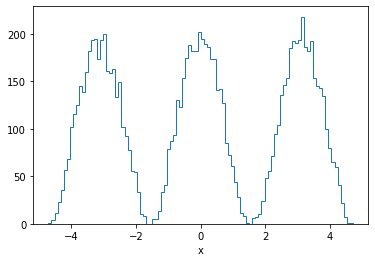

In [2]:
x = minkit.Parameter('x', bounds=(-1.5 * np.pi, +1.5 * np.pi))
a = minkit.Parameter('a', 1, bounds=(0.9, 1.1))
b = minkit.Parameter('b', 0, bounds=(0.01, 1))

formula = 'pow(cos(a * x + b), 2)'

pdf = minkit.FormulaPDF.unidimensional('pdf', formula, x, [a, b])

data = pdf.generate(10000)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

values, edges = minkit.data_plotting_arrays(data)

centers = 0.5 * (edges[1:] + edges[:-1])

ax.hist(centers, bins=edges, weights=values, histtype='step')
ax.set_xlabel(x.name);

We can also provide the primitive, so the integral can be computed.

In [3]:
primitive = '(2 * (a * x + b) + sin(2 * (a * x + b))) / (4 * a)'

pdf_with_primitive = minkit.FormulaPDF.unidimensional('pdf', formula, x, [a, b], primitive)

print(f'Normalization (numerical): {pdf.norm():.4f}')
print(f'Normalization (analytical): {pdf_with_primitive.norm():.4f}')

Normalization (numerical): 4.7124
Normalization (analytical): 4.7124


In the formula strings, only functions exposed by the *math.h* header are defined. MinKit creates the source code from both the formula and the primitive and compiles it at runtime.

## Defining complex PDFs
In order to add a new PDF to MinKit, where the evaluation function consists on more than one line, we must create a source XML file, and tell the MinKit package to add its directory to the list of directories to search for PDFs. For this example, we will create a C++ file from python on a temporary directory.

In [4]:
tmpdir = tempfile.TemporaryDirectory()

with open(os.path.join(tmpdir.name, 'CustomPDF.xml'), 'wt') as f:
    f.write('''
<PDF data="x" parameters="k">
  <preamble/>
  <function>
      return exp(k * x);
  </function>
  <integral bounds="xmin xmax">
      return 1. / k * (exp(k * xmax) - exp(k * xmin));
  </integral>
</PDF>
        ''')

The root of the XML tree must contain the fields *data*, referring to the data parameters to use; and *parameters* or *variable_parameters*, refferring to the parameters that the PDF uses. The latter must contain two names. The first rules the number of variable parameters and the second is the name of the pointer to the array of values. In addition, the XML parser accepts the following fields:

* *function* (required): refers to the code used to evaluate the PDF. All the mathematical functions must be available in C.
* *preamble* (optional): any kind of definition that needs to be added after the *include* directives.
* *integral* (optional): this field is optional since not all the PDFs have an analytical expression for the integral. It is recommended to fill this field when possible, since otherwise MinKit relies on numerical calculations to evaluate binned samples and calculate the normalization. This field must be composed of two parts: *bounds*, defining the names for the limits of the integration; and *code*, where the calculation of the integral is done. If working with more than one data parameter, *bounds* must contain the lower and upper bounds for each parameter, included consecutively (xmin, xmax, ymin, ymax, ...).
* *primitive* (optional): if provided, this function is used to calculate the integral of the function. If it is provided together with *integral*, the latter will be used.

Something very important to remember is that since we are dealing with XML format, the symbols <, >, &, " and ' are protected. We must use the escaped versions. Now we have to register the PDF. In order to be used in python, we must tell minkit to look for PDFs in the temporary directory.

In [5]:
minkit.add_pdf_src(tmpdir.name)

Now we have to build a python object to represent the PDF. This is directly done when inheriting from "minkit.SourcePDF", which will automatically set our PDF.

In [6]:
@minkit.register_pdf
class CustomPDF(minkit.SourcePDF):
    def __init__( self, name, x, k ):
        super(CustomPDF, self).__init__(name, [x], [k])

The *register_pdf* decorator is necessary if we want to save/load the PDF to/from JSON files. It is completely necessary that we call the function the same way we call the source file. The arguments to the *minkit.SourcePDF* constructor are the name of the PDF, the data parameters and the argument parameters. Now we can declare and use our function.

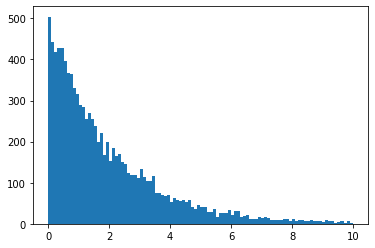

In [7]:
x = minkit.Parameter('x', bounds=(0, 10))
k = minkit.Parameter('k', -0.5)
pdf = CustomPDF('pdf', x, k)
data = pdf.generate(10000)
plt.hist(data['x'].as_ndarray(), bins=100);

## New PDFs with a variable number of arguments
It might happen that one wants to define a general function, which depends on a list of parameters that can vary (for example, a polynomial) from one construction to another.
This can be done on a similar way to that of the previous section, providing as a third argument to *minkit.SourcePDF* the list of extra arguments.

In [8]:
@minkit.register_pdf
class VarArgsCustomPDF(minkit.SourcePDF):
    def __init__( self, name, x, *coeffs ):
        super(VarArgsCustomPDF, self).__init__(name, [x], None, coeffs)

The XML file must be modified accordingly, using the field *variable_parameters*:

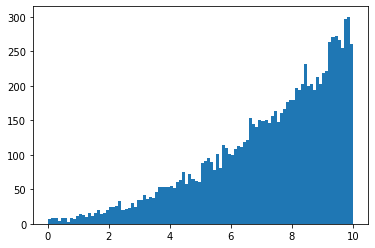

In [9]:
with open(os.path.join(tmpdir.name, 'VarArgsCustomPDF.xml'), 'wt') as f:
    f.write('''
<PDF data="x" variable_parameters="n p">
  <preamble/>
  <function>
      if ( n == 0 )
        return 1.;

      double out = x * p[n - 1];
      for ( int i = 0; i &lt; n; ++i )
        out = x * (out + p[n - i - 1]);
      return out + 1.;
  </function>
</PDF>
        ''')
    
x = minkit.Parameter('x', bounds=(0, 10))
p1 = minkit.Parameter('p1', +0.5)
pdf = VarArgsCustomPDF('pdf', x, p1)
data = pdf.generate(10000)
plt.hist(data['x'].as_ndarray(), bins=100);

## Building a PDF proxy from a data set
In MinKit it is also possible to create a PDF from arrays of data as a reference. Two different approaches can be adopted depending on our goal. If we know some of the points belonging to the probability density function distribution, then we can use the *InterpPDF* class, which can be used to fit both binned and unbinned data sets. On the other hand, if we only know the histogram of the PDF (this is, the integral per bins of the data parameters), we must use the *HistPDF* class, that can only be used to fit binned data sets with the same binning as the PDF.

### The InterpPDF class
In this case, we will build the *InterpPDF* class from a set of values following a Gaussan distribution function and show the resulting values.

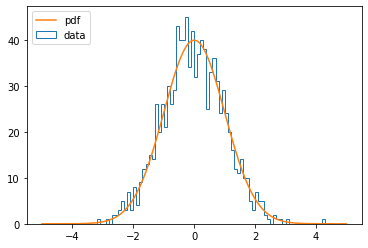

In [10]:
centers = np.linspace(-5, +5, 100)
values = np.exp(- 0.5 * centers**2)

m = minkit.Parameter('m', bounds=(-5, +5))

pdf = minkit.InterpPDF.from_ndarray('pdf', m, centers, values) # build the class from a binned data set

data = minkit.DataSet.from_ndarray(np.random.normal(0, 1, 1000), m)

fig = plt.figure()
ax = fig.gca()
values, edges = minkit.data_plotting_arrays(data, bins=100)
pdf_centers, pdf_values = minkit.pdf_plotting_arrays(pdf, values, edges)
ax.hist(0.5 * (edges[1:] + edges[:-1]), bins=edges, weights=values, histtype='step', color='C0', label='data');
ax.plot(pdf_centers, pdf_values, color='C1', label='pdf');
ax.legend(loc='upper left');

Note that the quality of the PDF proxy will depend on the input arrays. A highly binned data sample will make the interpolated values fluctuate according to the bin heights. Sometimes it is better to reduce the number of bins so the interpolation curve is more smooth.

### The HistPDF class
Ofently we get into the situation where we do not know the exact PDF we are working with, but we have a suitable histogram that represents its integral in bins of the data parameters. The HistPDF allows to act as a proxy to do binned fits using this information. In this example, the class is built from a binned data set, and is used to run a fit with two components.

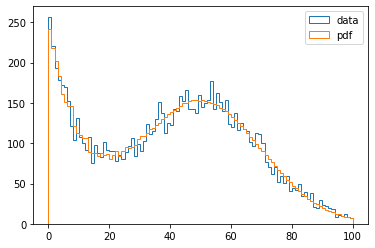

In [11]:
m = minkit.Parameter('m', bounds=(0, 100))

c = minkit.Parameter('c', 50, bounds=(25, 75))
s = minkit.Parameter('s', 20, bounds=(10, 30))
g = minkit.Gaussian('g', m, c, s)

k = minkit.Parameter('k', -0.1, bounds=(-1, 0))
e = minkit.Exponential('e', m, k)

y = minkit.Parameter('y', 0.75, (0, 1))

true_pdf = minkit.AddPDFs.two_components('true_pdf', g, e, y)

proxy_data = e.generate(10000).make_binned(100) # create the binned data sample to use as a reference

proxy = minkit.HistPDF.from_binned_dataset('proxy_e', proxy_data)

pdf = minkit.AddPDFs.two_components('pdf', g, proxy, y)

data = true_pdf.generate(10000).make_binned(100)

edges = data.edges.as_ndarray()
values = data.values.as_ndarray()
centers = 0.5 * (edges[1:] + edges[:-1])

fig = plt.figure()
ax = fig.gca()
ax.hist(centers, bins=edges, weights=values, histtype='step', color='C0', label='data');
pdf_values = pdf.evaluate_binned(data).as_ndarray() * values.sum()
ax.hist(centers, bins=edges, weights=pdf_values, histtype='step', color='C1', label='pdf');
ax.legend(loc='upper right');

Note that we can not draw the *unbinned* distribution of the PDF, so we must call the *evaluate_binned* method in order to get the values.